# Similarity analysis

We want to determine if the different batch simulated data is able to capture the biological signal that is present in the original data:  How much of the real input data is captured in the simulated batch data?

In other words, we want to ask: “do these datasets have similar patterns”?

To do this we will use [CCA](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.CCA.html) directly, as opposed to using SVCCA which uses the numpy library to compute the individual matrix operations (i.e. dot product, inversions).

**How does CCA work?**
Let A and B be the two datasets we want to compare.  CCA will find a set of basis vectors $(w, v)$ that maximizes the correlation of the two datasets A and B projected onto their respective bases, $corr(w^TA, v^TB)$.  In other words, we want to find the basis vectors (“space”) such that the projection of the data onto their respective basis vectors is highly correlated.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
import glob
from plotnine import *
from sklearn.cross_decomposition import CCA
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Load config file
config_file = "config_exp_2.txt"

d = {}
float_params = ["learning_rate", "kappa", "epsilon_std"]
str_params = ["analysis_name", "NN_architecture"]
lst_params = ["num_batches"]
with open(config_file) as f:
    for line in f:
        (name, val) = line.split()
        if name in float_params:
            d[name] = float(val)
        elif name in str_params:
            d[name] = str(val)
        elif name in lst_params:
            d[name] = ast.literal_eval(val)
        else:
            d[name] = int(val)

In [3]:
# Parameters
analysis_name = d["analysis_name"]
NN_architecture = d["NN_architecture"]
num_batches = d["num_batches"]

In [4]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))

batch_dir = os.path.join(
    base_dir,
    "data",
    "batch_simulated",
    analysis_name)

In [5]:
%%time
# Calculate similarity using CCA
cca = CCA(n_components=10)
output_list = []

for i in num_batches:
    print('Cacluating CCA of 1 batch vs {} batches..'.format(i))
    
    # Get batch 1 data
    batch_1_file = os.path.join(
        batch_dir,
        "Batch_1.txt.xz")

    batch_1 = pd.read_table(
        batch_1_file,
        header=0,
        index_col=0,
        sep='\t')

    # Simulated data with all samples in a single batch
    original_data_df =  batch_1
    
    # Get data with additional batch effects added
    batch_other_file = os.path.join(
        batch_dir,
        "Batch_"+str(i)+".txt.xz")

    batch_other = pd.read_table(
        batch_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Simulated data with i batch effects
    batch_data_df =  batch_other
    
    # CCA
    U_c, V_c = cca.fit_transform(original_data_df, batch_data_df)
    result = np.mean(np.corrcoef(U_c.T, V_c.T)) ## TOP singular value or mean singular value???
    
    output_list.append(result)

Cacluating CCA of 1 batch vs 1 batches..
Cacluating CCA of 1 batch vs 2 batches..
Cacluating CCA of 1 batch vs 5 batches..
Cacluating CCA of 1 batch vs 10 batches..
Cacluating CCA of 1 batch vs 20 batches..
Cacluating CCA of 1 batch vs 50 batches..
Cacluating CCA of 1 batch vs 100 batches..
Cacluating CCA of 1 batch vs 500 batches..
Cacluating CCA of 1 batch vs 1000 batches..
Cacluating CCA of 1 batch vs 2000 batches..
Cacluating CCA of 1 batch vs 3000 batches..
Cacluating CCA of 1 batch vs 6000 batches..
CPU times: user 20h 5min 17s, sys: 2h 22min 11s, total: 22h 27min 28s
Wall time: 4h 24min 24s


In [7]:
# Permute simulated data
shuffled_simulated_arr = []
num_samples = batch_1.drop(['group']).shape[0]

for i in range(num_samples):
    row = list(batch_1.values[i])
    shuffled_simulated_row = random.sample(row, len(row))
    shuffled_simulated_arr.append(shuffled_simulated_row)

shuffled_simulated_data = pd.DataFrame(shuffled_simulated_arr, 
                                       index=batch_1.index,
                                       columns=batch_1.drop(['group']).columns)
shuffled_simulated_data.head()

,5340,339,244,1567,1827,4981,2310,3929,1498,3226,...,2787,2526,3299,3097,5330,2854,494,5089,3662,1920
0,0.240206,0.444471,0.326427,0.348536,0.626239,0.401499,0.158951,0.267861,0.172687,0.578134,...,0.451033,0.257211,0.371355,0.231527,0.103554,0.495756,0.350689,0.592244,0.586795,0.448928
1,0.497854,0.848663,0.122899,0.187662,0.536208,0.321734,0.142022,0.177467,0.388858,0.470703,...,0.131413,0.546031,0.447694,0.649404,0.306864,0.346434,0.260167,0.267820,0.251083,0.687613
2,0.564426,0.503654,0.248456,0.293766,0.688346,0.236692,0.309201,0.177202,0.543971,0.270109,...,0.255852,0.406442,0.431800,0.207897,0.338784,0.431729,0.200618,0.366748,0.155646,0.666871
3,0.354406,0.433411,0.224454,0.427231,0.271116,0.332785,0.335140,0.603165,0.420325,0.612438,...,0.399636,0.673386,0.536044,0.568615,0.679063,0.415683,0.530435,0.311902,0.396421,0.310800
4,0.635726,0.381912,0.329401,0.417071,0.501013,0.510638,0.707202,0.477468,0.340920,0.455668,...,0.334849,0.296264,0.298088,0.247948,0.557853,0.438793,0.306220,0.347252,0.257882,0.402027


In [8]:
# CCA of permuted dataset (Negative control)
U_c, V_c = cca.fit_transform(original_data_df, shuffled_simulated_data)
permuted_corrcoef = np.mean(np.corrcoef(U_c.T, V_c.T))

threshold = pd.DataFrame(
    pd.np.tile(
        permuted_corrcoef,
        (len(num_batches), 1)),
    index=num_batches,
    columns=['cca_score'])

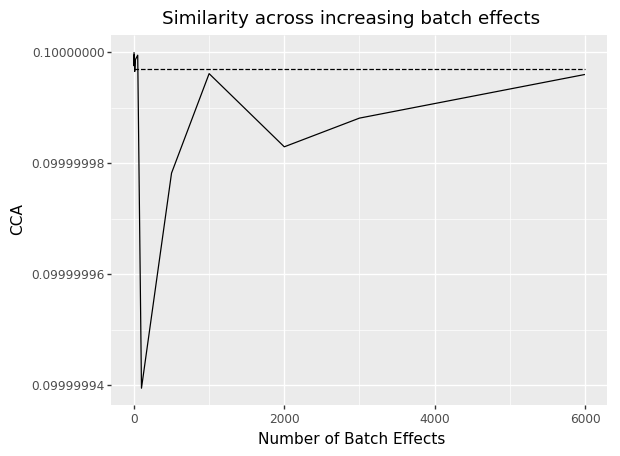

<ggplot: (-9223363251922350588)>

In [9]:
# Plot
cca_per_batch_effect = pd.DataFrame({'num_batch_effects':num_batches, 
                                     'cca_score': output_list
                                    })

ggplot(cca_per_batch_effect, aes(x='num_batch_effects', y='cca_score')) \
    + geom_line() \
    + geom_line(aes(x=num_batches, y='cca_score'), threshold, linetype='dashed') \
    + xlab('Number of Batch Effects') \
    + ylab('CCA') \
    + ggtitle('Similarity across increasing batch effects')